In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.models import load_model
from keras import backend as K
import tensorflow as tf
from scipy.misc import imresize
import matplotlib.pyplot as plt
%matplotlib inline

# fix random seed for reproducibility
np.random.seed(7)


Using TensorFlow backend.


# Load MNIST and some preprocessing

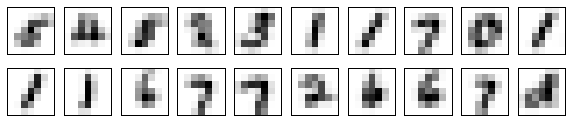

In [2]:
from keras.datasets import mnist
(Xtrain, Ytrain), (Xtest, Ytest) = mnist.load_data()

(ntrain, xdim, ydim) = Xtrain.shape
ntest = Xtest.shape[0]

# split train data in two parts
X_pr = Xtrain[30000:60000, :, :]
Y_pr = Ytrain[30000:60000]

Xtrain = Xtrain[0:30000, :, :];
Ytrain = Ytrain[0:30000]

# DOWNSAMPLE THE IMAGES
factor = 0.25

Xtrain_down = np.ones((Xtrain.shape[0], int(xdim*factor), int(ydim*factor)))
for i in range(Xtrain.shape[0]):
    Xtrain_down[i, :, :] = imresize(Xtrain[i,:,:], factor)

Xtest_down = np.ones((Xtest.shape[0], int(xdim*factor), int(ydim*factor)))
for i in range(Xtest.shape[0]):
    Xtest_down[i,:,:] = imresize(Xtest[i,:,:], factor)

    
X_pr_down = np.ones((X_pr.shape[0], int(xdim*factor), int(ydim*factor)))
for i in range(X_pr.shape[0]):
    X_pr_down[i,:,:] = imresize(X_pr[i,:,:], factor)

    
# VECTORIZE IMAGES
Xtrain_down = Xtrain_down.reshape(Xtrain.shape[0], int(xdim*factor)**2).astype('float32') / 255
Xtest_down  = Xtest_down.reshape(ntest, int(xdim*factor)**2).astype('float32') / 255
X_pr_down   = X_pr_down.reshape(X_pr.shape[0], int(xdim*factor)**2).astype('float32') / 255
Xtrain      = Xtrain.reshape(Xtrain.shape[0], xdim**2).astype('float32') / 255
Xtest       = Xtest.reshape(ntest, xdim**2).astype('float32') / 255

# Categorical labels
Ytrain_cat = np_utils.to_categorical(Ytrain, 10)
Ytest_cat = np_utils.to_categorical(Ytest, 10)

# VISUALIZATION 20 RANDOM TRAINING SAMPLES
# Create 20 subplots
fig, axes = plt.subplots(2, 10, figsize=(10, 2))

for i in range(2):
    for j in range(10):
        axes[i][j].imshow(Xtrain_down[np.random.randint(0, 3000),:].reshape(int(xdim*factor), 
                          int(ydim*factor)), cmap='gray_r', interpolation='nearest')
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        

# TRAIN A FULLY-CONNECTED NN WITH 4 "LINEAR" HIDDEN LAYERS 

In [3]:
# create model
model = Sequential()
model.add(Dense(128, input_shape=(int(xdim*factor)**2,)))
model.add(Dense(128))
model.add(Dense(128))
model.add(Dense(128))
model.add(Dense(10))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
with tf.device('/gpu:1'):
    model.fit(Xtrain_down, Ytrain_cat, nb_epoch=50, batch_size=32)

# evaluate the model
scores = model.evaluate(Xtest_down, Ytest_cat, verbose=0)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# # calculate predictions
# Ypredict = model.predict(Xtest)
# # round predictions
# rounded = [round(x[0]) for x in Ypredict]
# print(rounded)

# Save the model
model.save('linear_nn.h5')

# GET THE OUTPUT OF EACH LAYER AFTER TRAINING
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function
layer_outs = functor([X_pr_down, 1.])                       # compute on 2nd training set
layer_outs_test = functor([Xtest_down, 1.])                 # compute on test set
#print(layer_outs)


Epoch 1/50
30000/30000 [==============================] - 5s - loss: 9.3614 - acc: 0.1273     
Epoch 2/50
30000/30000 [==============================] - 3s - loss: 9.4645 - acc: 0.1259     
Epoch 3/50
30000/30000 [==============================] - 3s - loss: 9.4645 - acc: 0.1259     
Epoch 4/50
30000/30000 [==============================] - 3s - loss: 9.4645 - acc: 0.1259     
Epoch 5/50
30000/30000 [==============================] - 3s - loss: 9.4645 - acc: 0.1259     
Epoch 6/50
30000/30000 [==============================] - 3s - loss: 9.4645 - acc: 0.1259     
Epoch 7/50
30000/30000 [==============================] - 3s - loss: 9.4645 - acc: 0.1259     
Epoch 8/50
30000/30000 [==============================] - 3s - loss: 9.4645 - acc: 0.1259     
Epoch 9/50
30000/30000 [==============================] - 3s - loss: 9.4645 - acc: 0.1259     
Epoch 10/50
30000/30000 [==============================] - 3s - loss: 9.4645 - acc: 0.1259     
Epoch 11/50
30000/30000 [========================

In [4]:
import pickle
with open('linear_NN_layer_outputs.dat','wb') as f:
    pickle.dump([layer_outs, layer_outs_test], f)
f.close()